In [36]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [37]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

In [39]:
class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [40]:
layer_e = layer(4*4*64, g_dim)
layer_d = layer(g_dim, 4*4*64)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 1,16]),
    "W_e_conv2" : weight_variable([3,3,16,32]),
    "W_e_conv3" : weight_variable([3,3,32,64]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_e_conv3" : bias_variable([64])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

generator_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 1,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([1])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]
var_g = [generator_var[g] for g in generator_var]


In [41]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,28,28,1])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"]), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"]), encoder_var["b_e_conv2"]))    #7x7x32
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"]), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv3_reshape = tf.reshape(h_e_conv3, [-1,4*4*64])
    h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.relu)
#     h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.sigmoid)
    return h_e_layer
    
def decoder(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1)+decoder_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv1)+decoder_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv2)+decoder_var["b_d_conv3"])
    return h_d_conv3

def generator(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,4,4,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, generator_var["W_d_conv1"], output_shape_d_conv1)+generator_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, generator_var["W_d_conv2"], output_shape_d_conv1)+generator_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, generator_var["W_d_conv3"], output_shape_d_conv2)+generator_var["b_d_conv3"])
    return h_d_conv3

def discriminator(x):
    return decoder(encoder(x))

In [42]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [64]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])

gamma = 0.7
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)

# d_loss = loss(x_d)-k_t*loss(generator(x_g))
# d_loss = loss(x_d)
d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.00005).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.00005).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
update_k = k_t.assign(k_t + 0.001 * balancer)



In [65]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(5001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

step: 0  d-loss: 0.136249  g-loss: 0.0159932 k_t: 7.94568e-05 M_global: 0.215632
step: 1000  d-loss: 0.0984823  g-loss: 0.0697199 k_t: 0.070505 M_global: 0.106056
step: 2000  d-loss: 0.0734745  g-loss: 0.0517185 k_t: 0.00185107 M_global: 0.0737895
step: 3000  d-loss: 0.0604378  g-loss: 0.0299932 k_t: 0.0133957 M_global: 0.0734341
step: 4000  d-loss: 0.0559032  g-loss: 0.0282085 k_t: 0.0239831 M_global: 0.067977
step: 5000  d-loss: 0.0502302  g-loss: 0.0263172 k_t: 0.0335551 M_global: 0.0605754


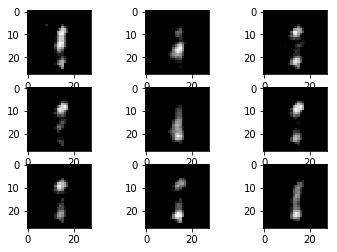

In [66]:
zz = sample_Z(batch_size, g_dim)
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [67]:
for step in range(5001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0517208  g-loss: 0.02711 k_t: 0.0335643 M_global: 0.0623622
step: 1000  d-loss: 0.0481819  g-loss: 0.0252125 k_t: 0.0429222 M_global: 0.0585364
step: 2000  d-loss: 0.0474612  g-loss: 0.0250353 k_t: 0.0518523 M_global: 0.0578556
step: 3000  d-loss: 0.0465925  g-loss: 0.0257993 k_t: 0.0591796 M_global: 0.0560036
step: 4000  d-loss: 0.0450627  g-loss: 0.0268577 k_t: 0.0647109 M_global: 0.0527035
step: 5000  d-loss: 0.0426794  g-loss: 0.0271147 k_t: 0.0686116 M_global: 0.048603


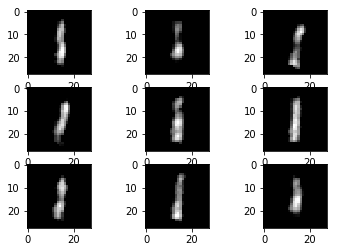

In [68]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [69]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0437418  g-loss: 0.0269832 k_t: 0.0686165 M_global: 0.0505254
step: 1000  d-loss: 0.0409052  g-loss: 0.0299561 k_t: 0.0710213 M_global: 0.0431996
step: 2000  d-loss: 0.0424518  g-loss: 0.0279883 k_t: 0.0731979 M_global: 0.0476626
step: 3000  d-loss: 0.0403412  g-loss: 0.0250878 k_t: 0.0769114 M_global: 0.0467725
step: 4000  d-loss: 0.0396197  g-loss: 0.0241722 k_t: 0.0810838 M_global: 0.0465132
step: 5000  d-loss: 0.0404879  g-loss: 0.0243284 k_t: 0.0853018 M_global: 0.0480289
step: 6000  d-loss: 0.0400223  g-loss: 0.0237646 k_t: 0.0894325 M_global: 0.0478864
step: 7000  d-loss: 0.0372744  g-loss: 0.0246604 k_t: 0.0932299 M_global: 0.0426146
step: 8000  d-loss: 0.0377209  g-loss: 0.0248852 k_t: 0.0968472 M_global: 0.0433375
step: 9000  d-loss: 0.0374074  g-loss: 0.0248783 k_t: 0.100243 M_global: 0.0429538
step: 10000  d-loss: 0.0377923  g-loss: 0.023904 k_t: 0.103361 M_global: 0.0445432


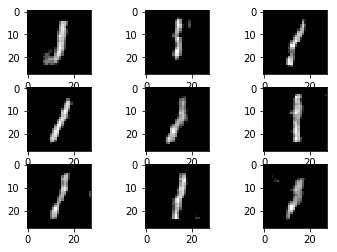

In [70]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [71]:
for step in range(10001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0368282  g-loss: 0.0243299 k_t: 0.103364 M_global: 0.0425532
step: 1000  d-loss: 0.0358103  g-loss: 0.0250998 k_t: 0.106134 M_global: 0.0403064
step: 2000  d-loss: 0.0377808  g-loss: 0.0260966 k_t: 0.108603 M_global: 0.0429488
step: 3000  d-loss: 0.0357425  g-loss: 0.0251388 k_t: 0.110822 M_global: 0.0403594
step: 4000  d-loss: 0.0357564  g-loss: 0.0253263 k_t: 0.112721 M_global: 0.0403128
step: 5000  d-loss: 0.0355108  g-loss: 0.0267035 k_t: 0.114312 M_global: 0.0388541
step: 6000  d-loss: 0.0360661  g-loss: 0.0247942 k_t: 0.115663 M_global: 0.0413933
step: 7000  d-loss: 0.0352206  g-loss: 0.0263744 k_t: 0.116739 M_global: 0.0387348
step: 8000  d-loss: 0.0356096  g-loss: 0.0260237 k_t: 0.11758 M_global: 0.0397145
step: 9000  d-loss: 0.0332554  g-loss: 0.0260495 k_t: 0.118134 M_global: 0.0369493
step: 10000  d-loss: 0.0349567  g-loss: 0.0260764 k_t: 0.118377 M_global: 0.0385977


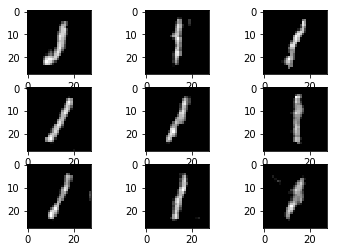

In [72]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [73]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0340952  g-loss: 0.0253028 k_t: 0.118378 M_global: 0.037751
step: 1000  d-loss: 0.0333088  g-loss: 0.0270807 k_t: 0.118484 M_global: 0.038036
step: 2000  d-loss: 0.033864  g-loss: 0.0268471 k_t: 0.11845 M_global: 0.0379603
step: 3000  d-loss: 0.0341148  g-loss: 0.0268324 k_t: 0.118271 M_global: 0.0380189
step: 4000  d-loss: 0.0334189  g-loss: 0.0272459 k_t: 0.118095 M_global: 0.0382369
step: 5000  d-loss: 0.0316123  g-loss: 0.0252848 k_t: 0.117875 M_global: 0.0356626
step: 6000  d-loss: 0.0338602  g-loss: 0.0256378 k_t: 0.117576 M_global: 0.037049
step: 7000  d-loss: 0.0336242  g-loss: 0.0252616 k_t: 0.117358 M_global: 0.0369393
step: 8000  d-loss: 0.0324495  g-loss: 0.0247874 k_t: 0.117203 M_global: 0.0353938
step: 9000  d-loss: 0.0318976  g-loss: 0.0249302 k_t: 0.117063 M_global: 0.035375
step: 10000  d-loss: 0.0324512  g-loss: 0.0248562 k_t: 0.116956 M_global: 0.0354636
step: 11000  d-loss: 0.0312159  g-loss: 0.0251996 k_t: 0.116944 M_global: 0.0354485
step: 12000

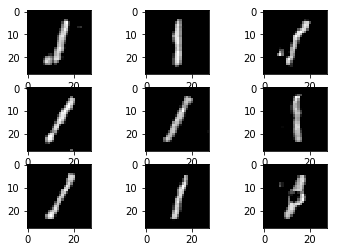

In [74]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [75]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0305137  g-loss: 0.0224852 k_t: 0.110107 M_global: 0.033597
step: 1000  d-loss: 0.0306815  g-loss: 0.0214078 k_t: 0.109888 M_global: 0.0347499
step: 2000  d-loss: 0.0298738  g-loss: 0.0225709 k_t: 0.109655 M_global: 0.0324221
step: 3000  d-loss: 0.0287963  g-loss: 0.0226713 k_t: 0.109465 M_global: 0.0320547
step: 4000  d-loss: 0.0298764  g-loss: 0.0233155 k_t: 0.109226 M_global: 0.0330424
step: 5000  d-loss: 0.0297325  g-loss: 0.0225477 k_t: 0.109007 M_global: 0.0322048
step: 6000  d-loss: 0.0302353  g-loss: 0.0241893 k_t: 0.108805 M_global: 0.0340495
step: 7000  d-loss: 0.0296335  g-loss: 0.0221211 k_t: 0.108599 M_global: 0.0323399
step: 8000  d-loss: 0.0283315  g-loss: 0.0210332 k_t: 0.108388 M_global: 0.0310059
step: 9000  d-loss: 0.0297412  g-loss: 0.0214128 k_t: 0.108156 M_global: 0.0330843
step: 10000  d-loss: 0.0294625  g-loss: 0.0228813 k_t: 0.107927 M_global: 0.032461
step: 11000  d-loss: 0.0289629  g-loss: 0.0222863 k_t: 0.107712 M_global: 0.0316953
step: 1

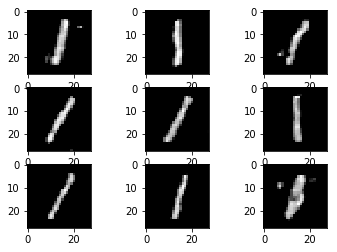

In [76]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [77]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0277589  g-loss: 0.0198299 k_t: 0.100123 M_global: 0.0307355
step: 1000  d-loss: 0.0281873  g-loss: 0.0220734 k_t: 0.100019 M_global: 0.0311919
step: 2000  d-loss: 0.0281267  g-loss: 0.0195296 k_t: 0.0998997 M_global: 0.0316026
step: 3000  d-loss: 0.0278598  g-loss: 0.0222948 k_t: 0.0997377 M_global: 0.0313198
step: 4000  d-loss: 0.0278518  g-loss: 0.021198 k_t: 0.0996217 M_global: 0.0301871
step: 5000  d-loss: 0.0284438  g-loss: 0.0201297 k_t: 0.0994967 M_global: 0.0316296
step: 6000  d-loss: 0.0283761  g-loss: 0.022137 k_t: 0.0994034 M_global: 0.03131
step: 7000  d-loss: 0.0274589  g-loss: 0.0215031 k_t: 0.0992746 M_global: 0.0303812
step: 8000  d-loss: 0.0280856  g-loss: 0.0205422 k_t: 0.0991064 M_global: 0.0306643
step: 9000  d-loss: 0.0278385  g-loss: 0.0211316 k_t: 0.0989973 M_global: 0.0301107
step: 10000  d-loss: 0.0284444  g-loss: 0.0210497 k_t: 0.0988804 M_global: 0.0308442
step: 11000  d-loss: 0.0281765  g-loss: 0.0214623 k_t: 0.0987642 M_global: 0.0305511

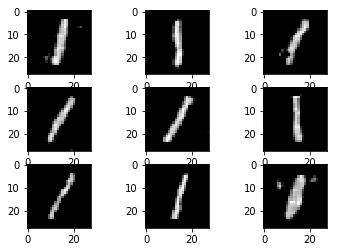

In [78]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [79]:
for step in range(50001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0274306  g-loss: 0.0201904 k_t: 0.0955901 M_global: 0.0297227
step: 1000  d-loss: 0.026616  g-loss: 0.0234708 k_t: 0.0955146 M_global: 0.0321281
step: 2000  d-loss: 0.026172  g-loss: 0.0185908 k_t: 0.0954357 M_global: 0.0289178
step: 3000  d-loss: 0.0256352  g-loss: 0.018883 k_t: 0.0954165 M_global: 0.0277598
step: 4000  d-loss: 0.0275621  g-loss: 0.0206477 k_t: 0.0953349 M_global: 0.0295542
step: 5000  d-loss: 0.0262312  g-loss: 0.0196204 k_t: 0.0952527 M_global: 0.0281497
step: 6000  d-loss: 0.0270102  g-loss: 0.0201377 k_t: 0.0952432 M_global: 0.0290402
step: 7000  d-loss: 0.0274902  g-loss: 0.01991 k_t: 0.0951719 M_global: 0.0300447
step: 8000  d-loss: 0.026973  g-loss: 0.0186331 k_t: 0.0951088 M_global: 0.0302336
step: 9000  d-loss: 0.0264394  g-loss: 0.0202125 k_t: 0.0950959 M_global: 0.0287209
step: 10000  d-loss: 0.0262759  g-loss: 0.0191128 k_t: 0.095088 M_global: 0.0286459
step: 11000  d-loss: 0.0266595  g-loss: 0.0217014 k_t: 0.0950238 M_global: 0.0303179


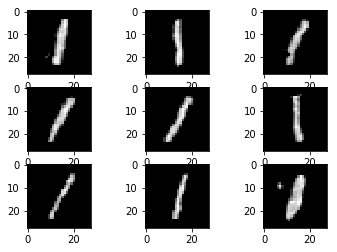

In [80]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [81]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0249302  g-loss: 0.0193555 k_t: 0.0896422 M_global: 0.0273551
step: 1000  d-loss: 0.0249862  g-loss: 0.0201405 k_t: 0.0896005 M_global: 0.0281778
step: 2000  d-loss: 0.0243154  g-loss: 0.0177337 k_t: 0.0895459 M_global: 0.0263021
step: 3000  d-loss: 0.0255446  g-loss: 0.0179785 k_t: 0.0895103 M_global: 0.028183
step: 4000  d-loss: 0.0249855  g-loss: 0.0189769 k_t: 0.0894553 M_global: 0.0269818
step: 5000  d-loss: 0.0252966  g-loss: 0.0193988 k_t: 0.0894243 M_global: 0.0275081
step: 6000  d-loss: 0.0246958  g-loss: 0.01785 k_t: 0.0893718 M_global: 0.0268448
step: 7000  d-loss: 0.0258992  g-loss: 0.0184963 k_t: 0.0893347 M_global: 0.0283414
step: 8000  d-loss: 0.0251546  g-loss: 0.0174256 k_t: 0.0893259 M_global: 0.0279834
step: 9000  d-loss: 0.0254305  g-loss: 0.0172345 k_t: 0.0892866 M_global: 0.0286133
step: 10000  d-loss: 0.0242839  g-loss: 0.0187017 k_t: 0.0892521 M_global: 0.0264877
step: 11000  d-loss: 0.0249667  g-loss: 0.0195718 k_t: 0.0892544 M_global: 0.0275

step: 98000  d-loss: 0.0237992  g-loss: 0.0175559 k_t: 0.087009 M_global: 0.0254996
step: 99000  d-loss: 0.0245673  g-loss: 0.0172266 k_t: 0.0869525 M_global: 0.0270843
step: 100000  d-loss: 0.0243227  g-loss: 0.0170243 k_t: 0.0868809 M_global: 0.0268387


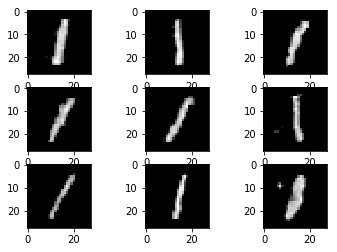

In [82]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [83]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0234113  g-loss: 0.0159448 k_t: 0.0868825 M_global: 0.0262094
step: 1000  d-loss: 0.0230905  g-loss: 0.0157071 k_t: 0.0868428 M_global: 0.0258656
step: 2000  d-loss: 0.0234247  g-loss: 0.0176101 k_t: 0.0867881 M_global: 0.025096
step: 3000  d-loss: 0.0238635  g-loss: 0.0180903 k_t: 0.0867096 M_global: 0.0257199
step: 4000  d-loss: 0.0236363  g-loss: 0.0190092 k_t: 0.0866073 M_global: 0.026594
step: 5000  d-loss: 0.0229838  g-loss: 0.0198357 k_t: 0.0865773 M_global: 0.0272461
step: 6000  d-loss: 0.0244167  g-loss: 0.0176172 k_t: 0.0865154 M_global: 0.0264822
step: 7000  d-loss: 0.0236923  g-loss: 0.0186018 k_t: 0.0864659 M_global: 0.026192
step: 8000  d-loss: 0.0240653  g-loss: 0.017548 k_t: 0.0864344 M_global: 0.0259415
step: 9000  d-loss: 0.0229753  g-loss: 0.0167014 k_t: 0.0863751 M_global: 0.024809
step: 10000  d-loss: 0.0237739  g-loss: 0.0168264 k_t: 0.0863398 M_global: 0.026059
step: 11000  d-loss: 0.0233182  g-loss: 0.0184952 k_t: 0.0862921 M_global: 0.0259695

step: 98000  d-loss: 0.0234085  g-loss: 0.017083 k_t: 0.0831167 M_global: 0.0251251
step: 99000  d-loss: 0.0228407  g-loss: 0.0165267 k_t: 0.083125 M_global: 0.024638
step: 100000  d-loss: 0.0223953  g-loss: 0.0173286 k_t: 0.0831318 M_global: 0.0244794


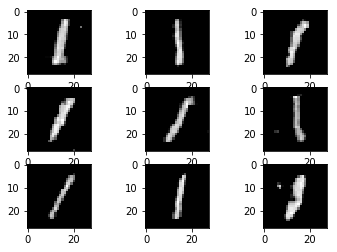

In [84]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [85]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0226799  g-loss: 0.0173469 k_t: 0.0831316 M_global: 0.0245835
step: 1000  d-loss: 0.0229315  g-loss: 0.0166416 k_t: 0.0831073 M_global: 0.0246932
step: 2000  d-loss: 0.02307  g-loss: 0.0162849 k_t: 0.0830493 M_global: 0.0252332
step: 3000  d-loss: 0.0220865  g-loss: 0.0180338 k_t: 0.0829756 M_global: 0.0251087
step: 4000  d-loss: 0.0240068  g-loss: 0.0171895 k_t: 0.0829203 M_global: 0.0260452
step: 5000  d-loss: 0.0237726  g-loss: 0.015279 k_t: 0.0828695 M_global: 0.0272869
step: 6000  d-loss: 0.0227047  g-loss: 0.0197672 k_t: 0.0827915 M_global: 0.0270695
step: 7000  d-loss: 0.0227965  g-loss: 0.0163603 k_t: 0.0827273 M_global: 0.0246946
step: 8000  d-loss: 0.0221936  g-loss: 0.0163569 k_t: 0.0826587 M_global: 0.0236706
step: 9000  d-loss: 0.0234733  g-loss: 0.0188079 k_t: 0.082601 M_global: 0.0263159
step: 10000  d-loss: 0.0225418  g-loss: 0.0179526 k_t: 0.0825498 M_global: 0.0251597
step: 11000  d-loss: 0.0227488  g-loss: 0.016904 k_t: 0.0825385 M_global: 0.024147

step: 98000  d-loss: 0.0224297  g-loss: 0.0173096 k_t: 0.0788322 M_global: 0.0244479
step: 99000  d-loss: 0.0222724  g-loss: 0.0170667 k_t: 0.0787222 M_global: 0.0241515
step: 100000  d-loss: 0.0221739  g-loss: 0.0163097 k_t: 0.0786649 M_global: 0.023567


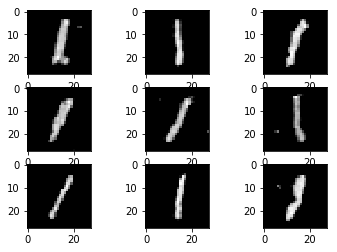

In [86]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

In [87]:
for step in range(500001):
    batch_x = mnist.train.next_batch(batch_size)[0]
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%1000==0:
        d_loss_train, g_loss_train, k_tt, M_global_train = sess.run([d_loss, g_loss, k_t, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_tt,"M_global:", M_global_train

step: 0  d-loss: 0.0215819  g-loss: 0.0172626 k_t: 0.0786641 M_global: 0.0241446
step: 1000  d-loss: 0.0215398  g-loss: 0.0164327 k_t: 0.0786028 M_global: 0.0232821
step: 2000  d-loss: 0.0230323  g-loss: 0.0169522 k_t: 0.0785139 M_global: 0.0244654
step: 3000  d-loss: 0.0219997  g-loss: 0.0168859 k_t: 0.0784213 M_global: 0.0238831
step: 4000  d-loss: 0.0215354  g-loss: 0.0161897 k_t: 0.0783264 M_global: 0.0230308
step: 5000  d-loss: 0.021182  g-loss: 0.0174201 k_t: 0.0782172 M_global: 0.0241834
step: 6000  d-loss: 0.0216598  g-loss: 0.0165182 k_t: 0.0781414 M_global: 0.0234034
step: 7000  d-loss: 0.0209245  g-loss: 0.0147065 k_t: 0.0780708 M_global: 0.022817
step: 8000  d-loss: 0.0229201  g-loss: 0.0168002 k_t: 0.0780045 M_global: 0.0243918
step: 9000  d-loss: 0.0217083  g-loss: 0.0161098 k_t: 0.0778965 M_global: 0.0229988
step: 10000  d-loss: 0.0226224  g-loss: 0.0165963 k_t: 0.0778228 M_global: 0.0240574
step: 11000  d-loss: 0.0222504  g-loss: 0.0173283 k_t: 0.0777405 M_global: 0.024

step: 97000  d-loss: 0.0206475  g-loss: 0.0140829 k_t: 0.0747681 M_global: 0.0228079
step: 98000  d-loss: 0.0209108  g-loss: 0.0174035 k_t: 0.0747294 M_global: 0.024067
step: 99000  d-loss: 0.0222497  g-loss: 0.0163544 k_t: 0.0746906 M_global: 0.0235468
step: 100000  d-loss: 0.0225494  g-loss: 0.0159509 k_t: 0.074668 M_global: 0.0244078
step: 101000  d-loss: 0.0222516  g-loss: 0.0158348 k_t: 0.0746521 M_global: 0.0240024
step: 102000  d-loss: 0.0212595  g-loss: 0.0166641 k_t: 0.0746318 M_global: 0.0234151
step: 103000  d-loss: 0.0223601  g-loss: 0.0140425 k_t: 0.0745824 M_global: 0.0257501
step: 104000  d-loss: 0.0219373  g-loss: 0.015829 k_t: 0.074566 M_global: 0.023471
step: 105000  d-loss: 0.0216291  g-loss: 0.0177625 k_t: 0.0744923 M_global: 0.0246482
step: 106000  d-loss: 0.0225825  g-loss: 0.0148599 k_t: 0.0744433 M_global: 0.025411
step: 107000  d-loss: 0.0224585  g-loss: 0.015287 k_t: 0.0743968 M_global: 0.0248259
step: 108000  d-loss: 0.0209554  g-loss: 0.0140462 k_t: 0.074353

step: 193000  d-loss: 0.0214509  g-loss: 0.0146965 k_t: 0.0717524 M_global: 0.0235627
step: 194000  d-loss: 0.020331  g-loss: 0.0163627 k_t: 0.0717381 M_global: 0.0228141
step: 195000  d-loss: 0.0216747  g-loss: 0.0155658 k_t: 0.0717154 M_global: 0.023179
step: 196000  d-loss: 0.0207697  g-loss: 0.0160158 k_t: 0.0716724 M_global: 0.0225911
step: 197000  d-loss: 0.0212474  g-loss: 0.014422 k_t: 0.0716694 M_global: 0.0234557
step: 198000  d-loss: 0.0216829  g-loss: 0.0150851 k_t: 0.0716559 M_global: 0.0236135
step: 199000  d-loss: 0.0208074  g-loss: 0.0152484 k_t: 0.0716628 M_global: 0.0219818
step: 200000  d-loss: 0.0208032  g-loss: 0.0173845 k_t: 0.0716163 M_global: 0.023999
step: 201000  d-loss: 0.021395  g-loss: 0.0157209 k_t: 0.0715922 M_global: 0.022564
step: 202000  d-loss: 0.0209418  g-loss: 0.0146967 k_t: 0.0715472 M_global: 0.022692
step: 203000  d-loss: 0.0211928  g-loss: 0.0155984 k_t: 0.0714692 M_global: 0.0223246
step: 204000  d-loss: 0.0213961  g-loss: 0.0154128 k_t: 0.071

step: 289000  d-loss: 0.0202867  g-loss: 0.0145005 k_t: 0.069711 M_global: 0.0217052
step: 290000  d-loss: 0.0194977  g-loss: 0.0134978 k_t: 0.0695828 M_global: 0.021245
step: 291000  d-loss: 0.0205873  g-loss: 0.013967 k_t: 0.0693911 M_global: 0.022679
step: 292000  d-loss: 0.019456  g-loss: 0.0143119 k_t: 0.0692489 M_global: 0.0204482
step: 293000  d-loss: 0.0201924  g-loss: 0.0142169 k_t: 0.0691162 M_global: 0.0217806
step: 294000  d-loss: 0.0209927  g-loss: 0.0162843 k_t: 0.0690192 M_global: 0.0229193
step: 295000  d-loss: 0.0205488  g-loss: 0.0152316 k_t: 0.0688806 M_global: 0.0217109
step: 296000  d-loss: 0.0205626  g-loss: 0.015771 k_t: 0.0688169 M_global: 0.0222653
step: 297000  d-loss: 0.0200109  g-loss: 0.014574 k_t: 0.0687729 M_global: 0.0211484
step: 298000  d-loss: 0.0207325  g-loss: 0.0141732 k_t: 0.0687122 M_global: 0.0227277
step: 299000  d-loss: 0.0210331  g-loss: 0.0155337 k_t: 0.0686336 M_global: 0.0221634
step: 300000  d-loss: 0.020741  g-loss: 0.0153128 k_t: 0.0685

step: 385000  d-loss: 0.0198261  g-loss: 0.0146678 k_t: 0.0658606 M_global: 0.0209055
step: 386000  d-loss: 0.0196279  g-loss: 0.0148395 k_t: 0.0658719 M_global: 0.0210211
step: 387000  d-loss: 0.0197709  g-loss: 0.0143585 k_t: 0.0658462 M_global: 0.0208594
step: 388000  d-loss: 0.0200152  g-loss: 0.0139121 k_t: 0.0657884 M_global: 0.0216697
step: 389000  d-loss: 0.0201159  g-loss: 0.0140652 k_t: 0.0657611 M_global: 0.0217042
step: 390000  d-loss: 0.0199486  g-loss: 0.0160404 k_t: 0.0657254 M_global: 0.0223412
step: 391000  d-loss: 0.020095  g-loss: 0.0150964 k_t: 0.0657192 M_global: 0.0214225
step: 392000  d-loss: 0.0193576  g-loss: 0.0157221 k_t: 0.0657164 M_global: 0.0218393
step: 393000  d-loss: 0.0195608  g-loss: 0.0150544 k_t: 0.0656764 M_global: 0.0212193
step: 394000  d-loss: 0.0199164  g-loss: 0.0140442 k_t: 0.065589 M_global: 0.0213797
step: 395000  d-loss: 0.019576  g-loss: 0.013508 k_t: 0.0654951 M_global: 0.0212753
step: 396000  d-loss: 0.0197054  g-loss: 0.0146585 k_t: 0.

step: 481000  d-loss: 0.0193183  g-loss: 0.0142298 k_t: 0.0633377 M_global: 0.0202957
step: 482000  d-loss: 0.0192492  g-loss: 0.0145785 k_t: 0.0632793 M_global: 0.02063
step: 483000  d-loss: 0.0187397  g-loss: 0.0133036 k_t: 0.0632463 M_global: 0.0199842
step: 484000  d-loss: 0.0193378  g-loss: 0.0153674 k_t: 0.0632345 M_global: 0.0214603
step: 485000  d-loss: 0.0199923  g-loss: 0.0168174 k_t: 0.063193 M_global: 0.0231339
step: 486000  d-loss: 0.0202906  g-loss: 0.0147462 k_t: 0.0631128 M_global: 0.0213301
step: 487000  d-loss: 0.0201183  g-loss: 0.0135935 k_t: 0.0631503 M_global: 0.0220669
step: 488000  d-loss: 0.0198204  g-loss: 0.0137077 k_t: 0.0631062 M_global: 0.0214575
step: 489000  d-loss: 0.0199008  g-loss: 0.0159473 k_t: 0.0631269 M_global: 0.0222196
step: 490000  d-loss: 0.019194  g-loss: 0.0132831 k_t: 0.0630628 M_global: 0.0207708
step: 491000  d-loss: 0.019611  g-loss: 0.0143368 k_t: 0.0630736 M_global: 0.0205391
step: 492000  d-loss: 0.0191692  g-loss: 0.0143764 k_t: 0.0

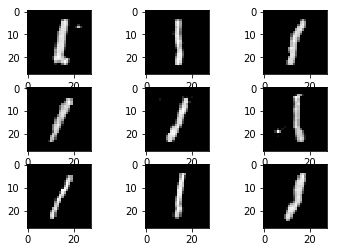

In [92]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(discriminator(g_sample), feed_dict = {x_g: zz})
# gg = sess.run(decoder(x_g), feed_dict = {x_g: zz})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: x_train})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')